# Data Preparation

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image as kimage
from tqdm import tqdm 
import matplotlib
import matplotlib.pyplot as plt

PATH = '/content/drive/MyDrive/AI Insight/Hw 17 + 18/'
images = []
lists = [i for i in range(9908)]

for index in tqdm(lists):
    img = kimage.load_img(PATH+'images_mr/%d.jpg' % (index), target_size=(86, 128))    
    img_np = kimage.img_to_array(img)
    images.append(img_np)
    
# convert to np.array
images_np = np.array(images)

# reduce memory used and save
images_np = images_np.astype(np.uint8)
np.save('images_mr.npy', images_np)

100%|██████████| 9908/9908 [35:14<00:00,  4.69it/s]


(9908, 86, 128, 3)


# CNN - Cosine

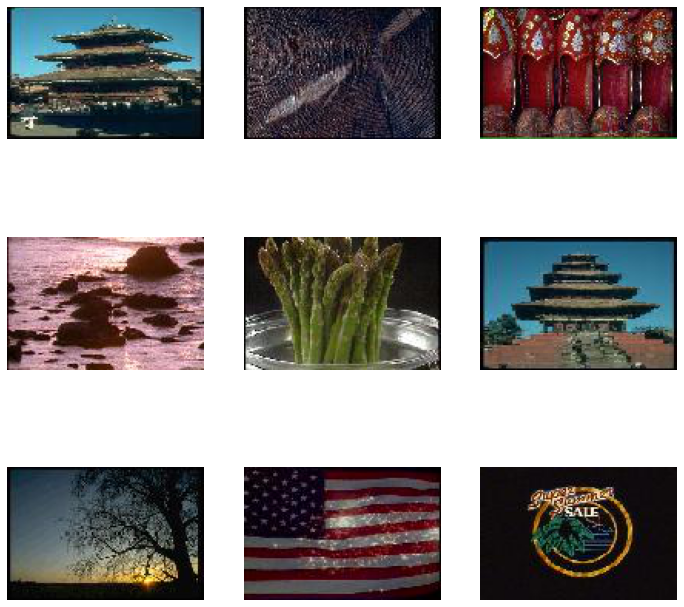

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
import matplotlib.pyplot as plt

PATH = '/content/drive/MyDrive/AI Insight/Hw 17 + 18/'

# set up model
model = tf.keras.applications.InceptionV3(input_shape=(86,128,3), include_top=False, weights='imagenet')

# load data
data = np.load(PATH+'images_mr.npy', allow_pickle=True)
data = data.astype(np.float32)
data = preprocess_input(data)
data_features = model.predict(data)

# load query
query = kimage.load_img(PATH+'q2.jpg', target_size=(86, 128))

query_np = kimage.img_to_array(query) #(86, 128, 3)
query_np = np.expand_dims(query_np, axis=0)  #(1, 86, 128, 3)
query_np = preprocess_input(query_np) # (1, 86,128,3)

query_features = model.predict(query_np)

# compute similarity
query_features = np.reshape(query_features, (1, -1))
data_features  = np.reshape(data_features, (data.shape[0], -1))
sims = cosine_similarity(query_features, data_features).squeeze()

# sorting
def getKey(item):
    return item[0]

lists = [i for i in range(data.shape[0])]
tps = zip(sims.tolist(), lists)
tps_sorted = sorted(tps, key=getKey, reverse=True)

# results
data_show = np.load(PATH+'images_mr.npy', allow_pickle=True)
data_show = data_show.astype(np.float32)

fig = plt.figure(figsize=(12,12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    index = tps_sorted[i-1][1]
    img = data_show[index]
    fig.add_subplot(rows, columns, i)
    
    plt.axis('off')
    plt.imshow(img/255.0)

# Precompute Features

In [ ]:
model = tf.keras.applications.InceptionV3(input_shape=(86,128,3), include_top=False, weights='imagenet')
data = np.load(PATH+'images_mr.npy', allow_pickle=True)
data = data.astype(np.float32)
data = preprocess_input(data)
data_features = model.predict(data)
np.save(PATH+'images_features.npy', data_features)

# CNN - Correlation

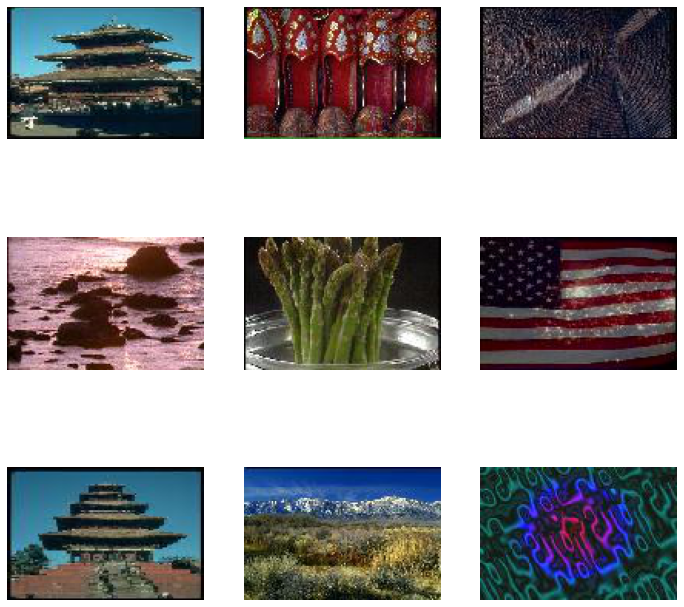

In [ ]:
import numpy as np
import tensorflow as tf
from scipy.stats.stats import pearsonr
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
import matplotlib.pyplot as plt

PATH = '/content/drive/MyDrive/AI Insight/Hw 17 + 18/'

# set up model
model = tf.keras.applications.InceptionV3(input_shape=(86,128,3), include_top=False, weights='imagenet')

# load data
data_features = np.load(PATH+'images_features.npy', allow_pickle=True)

# load query
query = kimage.load_img(PATH+'q2.jpg', target_size=(86, 128))

query_np = kimage.img_to_array(query) #(86, 128, 3)
query_np = np.expand_dims(query_np, axis=0)  #(1, 86, 128, 3)
query_np = preprocess_input(query_np) # (1, 86,128,3)

query_features = model.predict(query_np)

# computing correlation
query_features = np.reshape(query_features, (1, -1))
data_features  = np.reshape(data_features, (data_features.shape[0], -1))

corr_list = []
for i in range(data_features.shape[0]):
  corr = pearsonr(query_features[0], data_features[i])
  corr_list.append(corr)

# sorting
def getKey(item):
    return item[0]

lists = [i for i in range(data_features.shape[0])]
tps = zip(corr_list, lists)
tps_sorted = sorted(tps, key=getKey, reverse=True)

# results
data_show = np.load(PATH+'images_mr.npy', allow_pickle=True)
data_show = data_show.astype(np.float32)

fig = plt.figure(figsize=(12,12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    index = tps_sorted[i-1][1]

    img = data_show[index]
    fig.add_subplot(rows, columns, i)
    
    plt.axis('off')
    plt.imshow(img/255.0)

# CNN-Cosine_DifferentSize

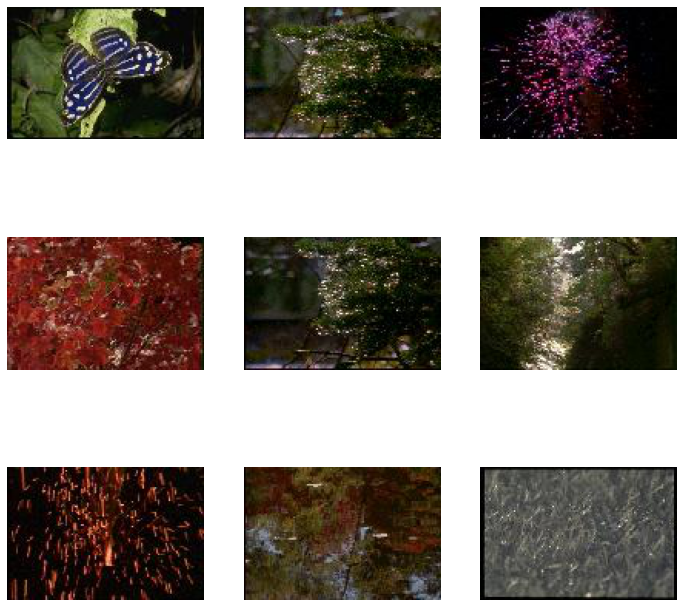

In [ ]:
import numpy as np
import tensorflow as tf
from scipy.stats.stats import pearsonr
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
import matplotlib.pyplot as plt

PATH = '/content/drive/MyDrive/AI Insight/Hw 17 + 18/'

# set up model
model = tf.keras.applications.InceptionV3(input_shape=(86,128,3), include_top=False, weights='imagenet')

def compute_feature_help(data):
  for i in range(1,19):
    data = model.layers[i](data)
  return data

def compute_features(data):
  result = []
  chunk_size = 500
  num_chunks = data.shape[0]//chunk_size + 1   #roughtly

  for c in range(num_chunks):
    # batch
    begin = chunk_size*c
    end   = min(chunk_size*(c+1), data.shape[0])
    data_chunk = data[begin:end]

    # compute features for the batch
    data_chunk = compute_feature_help(data_chunk)
    result.append(data_chunk)

  return result

# load data
data = np.load(PATH+'images_mr.npy', allow_pickle=True)
data = data.astype(np.float32)
data = preprocess_input(data)

features_database = compute_features(data)
features_database = np.concatenate(features_database, axis=0)

# load query
query = kimage.load_img(PATH+'q1.jpg', target_size=(86, 128))

query_np = kimage.img_to_array(query)
query_np = np.expand_dims(query_np, axis=0)
query_np = preprocess_input(query_np)

feature_query = compute_features(query_np)

# compute similarity
feature_query = np.reshape(feature_query,  (1, -1))
features_database = np.reshape(features_database, (data.shape[0], -1))

sims = cosine_similarity(feature_query, features_database).squeeze()

# sorting
def getKey(item):
    return item[0]

lists = [i for i in range(data.shape[0])]
tps = zip(sims.tolist(), lists)
tps_sorted = sorted(tps, key=getKey, reverse=True)

# results
data_show = np.load(PATH+'images_mr.npy', allow_pickle=True)
data_show = data_show.astype(np.float32)

fig = plt.figure(figsize=(12,12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    index = tps_sorted[i-1][1]
    img = data_show[index]
    fig.add_subplot(rows, columns, i)
    
    plt.axis('off')
    plt.imshow(img/255.0)